# Analyse de donnés exemplaire: Dispositif electrons

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pylab as plt
from IPython.display import Markdown as md
from __future__ import print_function, division # bring the print function and division of Python3 to 2.7

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'axes.titlesize': 24})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'xtick.labelsize' : 16})
plt.rcParams.update({'ytick.labelsize' : 16})
plt.rcParams.update({'legend.fontsize' : 18})
plt.rcParams.update({'figure.dpi': 150.})


## 1) Prerequisites

In [15]:
def gauss(x, mu, sigma, N):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)

def F(x):
    return 1/2 * (1 + sp.special.erf(x/np.sqrt(2)))

def trun_gauss(x, mu, sigma, N, alpha, beta):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)/(F((beta - mu)/sigma) - F((alpha - mu)/sigma))

def trun_double_gauss(x, mu, sigma, N, alpha, beta):
    return ((N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)/(F((beta - mu)/sigma) - F((alpha - mu)/sigma))) + (N / np.sqrt(2*np.pi)/np.sqrt(2)/sigma * np.exp(-0.5*(x - 2*mu)**2/(np.sqrt(2)*sigma)**2)/(F((beta - 2*mu)/np.sqrt(2)/sigma) - F((alpha - 2*mu)/np.sqrt(2)/sigma))))
        

class GaussFit:
    def __init__(self,method):
        assert method in ['llh','chi2'],'This method is not implemented - choose llh or chi2!'
        self.method = method
        self.uncertaintyOffset = 0.5 if (method=='llh') else 1.
        self.mu_grid = np.array([])
        self.sigma_grid = np.array([])
        self.likelihood = np.array([])
        self.bestfit = [0.,0.]
        self.fiterror = [0.,0.]
        self.fitrange = [0.,0.]

    def setMuGrid(self,mu_min,mu_max,step):
        self.mu_grid = np.arange(mu_min, mu_max, step)

    def setSigmaGrid(self,sigma_min,sigma_max,step):
        self.sigma_grid = np.arange(sigma_min, sigma_max, step)
        
    def setFitRange(self,xmin,xmax):
        self.fitrange = [xmin,xmax]

    def fit(self,data):
        
        assert len(self.mu_grid) > 1, 'Please choose the scan grid for $\mu$ first!'
        assert len(self.sigma_grid) > 1, 'Please choose the scan grid for $\sigma$ first!'
        assert self.fitrange[0] != self.fitrange[1], 'Please choose the fit range first!'
        
        if self.method == 'llh':
            assert data.ndim == 1,'Data does not have the right format for the chosen fitting method!'
            
            data = data[(data > self.fitrange[0])&(data < self.fitrange[1])]

            L_tmp = []
            for m in self.mu_grid:
                L_tmp_m = []
                for s in self.sigma_grid:
                    P = trun_gauss(data, m, s, 1., self.fitrange[0], self.fitrange[1])
                    L_tmp_m.append(-np.sum(np.log(P)))
                L_tmp.append(L_tmp_m)
            self.likelihood = np.array(L_tmp)   
            
        elif self.method == 'chi2':
            assert len(data) == 2,'Data does not have the right format for the chosen fitting method!'

            binEdges = data[1]
            binCenters = (data[1][:-1]+data[1][1:])/2
            binwidth = np.diff(binEdges)[0]
            
            trunc = np.where((binCenters > self.fitrange[0])&(binCenters < self.fitrange[1]))
            hist = data[0][trunc]
            bins = binCenters[trunc]
        
            chi2_tmp = []
            for m in self.mu_grid:
                chi2_tmp_m = []
                for s in self.sigma_grid:
                    chi2=0.
                    P = trun_gauss(bins, m, s, 1.*np.sum(hist)*binwidth, self.fitrange[0], self.fitrange[1])
                    chi2 = np.sum((hist - P)**2/hist) 
                    chi2_tmp_m.append(chi2)
                chi2_tmp.append(chi2_tmp_m)
            self.likelihood = np.array(chi2_tmp)

            
        i_best = np.where(self.likelihood == self.likelihood.min())

        self.bestfit = [self.mu_grid[i_best[0]][0], self.sigma_grid[i_best[1]][0]]

        slice_sigmaBest = self.likelihood[ : , i_best[1] ].flatten()
        slice_muBest =  self.likelihood[ i_best[0] , : ].flatten()
                
        mu_up   = self.mu_grid[(slice_sigmaBest > self.likelihood.min()+self.uncertaintyOffset) & (self.mu_grid > self.bestfit[0])]
        mu_down = self.mu_grid[(slice_sigmaBest > self.likelihood.min()+self.uncertaintyOffset) & (self.mu_grid < self.bestfit[0])]

        sigma_up   = self.sigma_grid[(slice_muBest > self.likelihood.min()+self.uncertaintyOffset) & (self.sigma_grid > self.bestfit[1])]
        sigma_down = self.sigma_grid[(slice_muBest > self.likelihood.min()+self.uncertaintyOffset) & (self.sigma_grid < self.bestfit[1])]

        self.fiterror = [(mu_up.min()- mu_down.max())/2., (sigma_up.min()- sigma_down.max())/2.]

    def getBestFit(self):
        return [self.bestfit,self.fiterror]
    
    def plotLikelihood(self):
        fig, ax = plt.subplots(1,1, figsize=(9,8))

        mesh = ax.pcolormesh(self.sigma_grid, self.mu_grid, self.likelihood, cmap='PuBu_r')
        contours = ax.contour(self.sigma_grid, self.mu_grid, self.likelihood,
                              [self.likelihood.min() + self.uncertaintyOffset,
                               self.likelihood.min() + 4*self.uncertaintyOffset,
                               self.likelihood.min() + 9.*self.uncertaintyOffset],
                              colors='white')
        fmt = {}
        strs = ['1$\sigma$', '2$\sigma$', '3$\sigma$']
        for l, s in zip(contours.levels, strs):
            fmt[l] = s
        cbar = fig.colorbar(mesh)
        if self.method == 'llh':
            cbar.ax.set_ylabel('-$\log \mathcal{L}$')
        else:
            cbar.ax.set_ylabel('$\chi^2$')
        ax.clabel(contours, contours.levels, inline=1, fmt=fmt, fontsize=20)
        ax.plot(self.bestfit[1], self.bestfit[0], marker='o',color='r')
        ax.set_xlabel('$\sigma$')
        ax.set_ylabel('$\mu$')
        
        plt.tight_layout()

        return fig
                
    def plotResult(self,data,nBins,xLabel,yLabel,dataLabel,second=False):
        
        latex = {}
        latex['llh'] = "-$\log \mathcal{L}$"
        latex['chi2'] = "$\chi^2$"
        
        norm = len( data[(data > self.fitrange[0])&(data < self.fitrange[1])] )
        
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        
        hist,bins, _ = ax.hist(data,bins = nBins,density=False, label=dataLabel)
        binwidth = np.diff(bins)[1]

        fitLabel = "Best Fit: $\mu$={:.2f}$\pm${:.2f}, $\sigma$={:.2f}$\pm${:.2f}".format(self.bestfit[0], self.fiterror[0], self.bestfit[1],self.fiterror[1])
        
        x = np.linspace(self.fitrange[0],self.fitrange[1],1000)
        ax.plot(x, trun_gauss(x, self.bestfit[0], self.bestfit[1], 1.*norm*binwidth ,
                              self.fitrange[0], self.fitrange[1]), lw =3 , color ='r', label=fitLabel)
        
        if second:
            x2 = np.linspace(1.5*self.fitrange[0],2*self.fitrange[1],1000)
            ax.plot(x2, trun_gauss(x2, 2*self.bestfit[0], np.sqrt(2)*self.bestfit[1], 0.2*1.*norm*binwidth ,
                              1.5*self.fitrange[0], 2*self.fitrange[1]), lw =3 , color ='g', label='Expected 2pe peak')
        
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        ax.set_ylim(0,1.5*hist.max())
        ax.legend(loc="upper right")
        ax.set_title('Gaussian fit with '+latex[self.method]+' method')
        
        plt.tight_layout()

        return fig

## 2) MonteCarlo Simulation

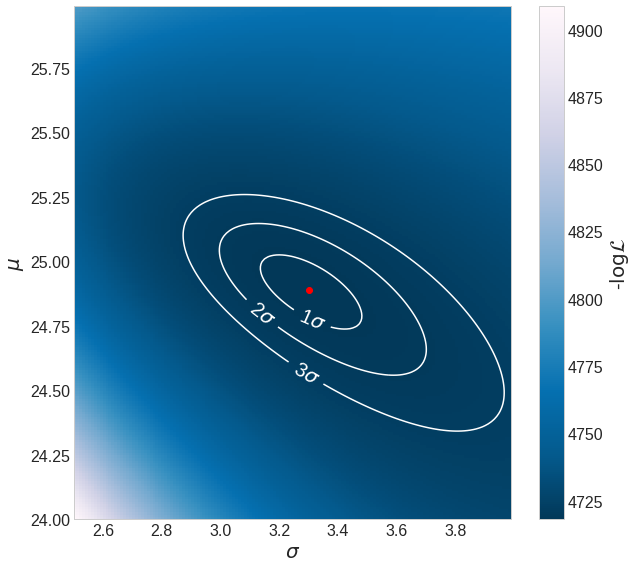

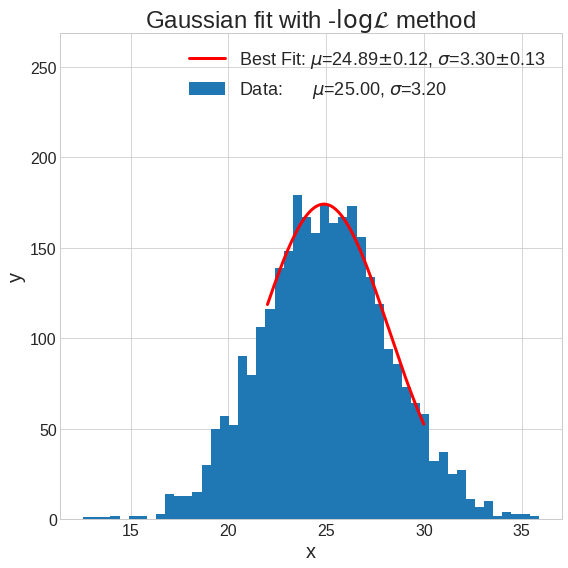

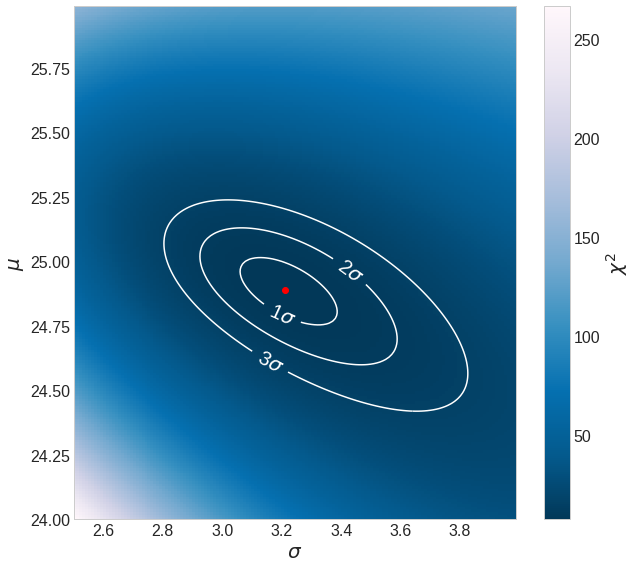

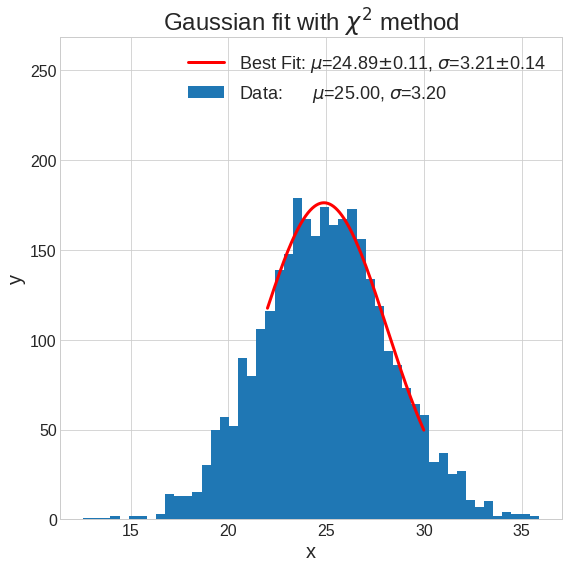

In [3]:
# Definition of the MC truth
mu_mc = 25.0
sigma_mc = 3.2
N = 27.
xmin = mu_mc - 5*sigma_mc
xmax = mu_mc + 5*sigma_mc

# number of MC events
mc_events = 100000

# genererate MC gaussian
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = N*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, mu_mc, sigma_mc, N)

# Full gaussian:
data = x[np.where(y < yprime)]
dataLabel = "Data:      $\mu$={:.2f}, $\sigma$={:.2f}".format(mu_mc,sigma_mc)

# LLH fit of truncated gaussian
MC_fit_llh = GaussFit('llh')
MC_fit_llh.setMuGrid(24.,26.,0.01)
MC_fit_llh.setSigmaGrid(2.5,4.0,0.01)
MC_fit_llh.setFitRange(22,30)
MC_fit_llh.fit(data)
MC_fit_llh.plotLikelihood().savefig("plots/Likelihood_MC.pdf")
MC_fit_llh.plotResult(data,50,'x','y',dataLabel).savefig("plots/LLH_Fit_MC.pdf")

# chi2 fit of truncated gaussian
binned_data = np.histogram(data,bins=50)
MC_fit_chi2 = GaussFit('chi2')
MC_fit_chi2.setMuGrid(24.,26.,0.01)
MC_fit_chi2.setSigmaGrid(2.5,4.0,0.01)
MC_fit_chi2.setFitRange(22,30)
MC_fit_chi2.fit(binned_data)
MC_fit_chi2.plotLikelihood().savefig("plots/Chi2_MC.pdf")
MC_fit_chi2.plotResult(data,50,'x','y',dataLabel).savefig("plots/Chi2_fit_MC.pdf")

## 3) Data Analysis Example 1: Electron Setup with VME ADC and LLH fit

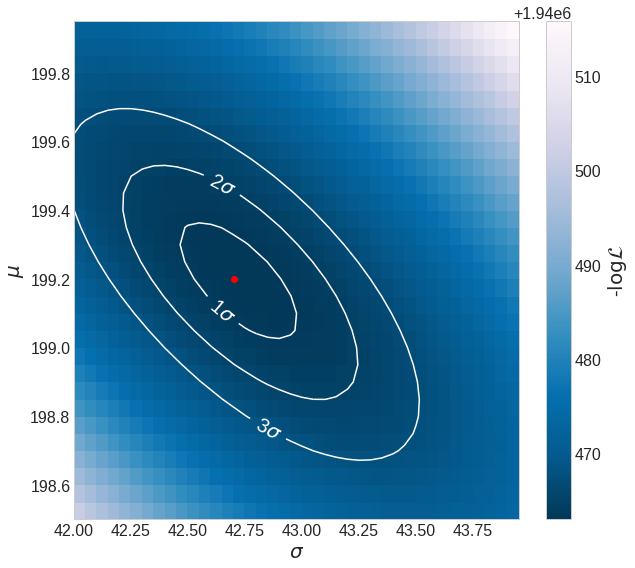

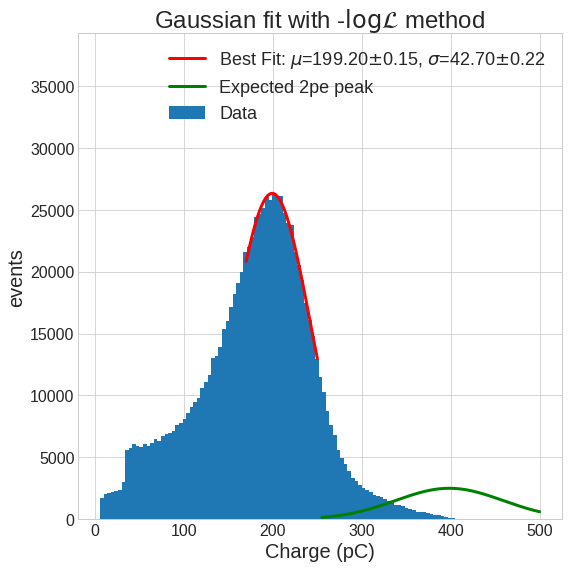

In [16]:
adcToCharge_VME = 0.1
Exp_data_VME = np.loadtxt('exampleData/2019_electronSetup.txt')
Exp_data_VME = Exp_data_VME*adcToCharge_VME

Electron_fit_llh = GaussFit('llh')
Electron_fit_llh.setMuGrid(198.5,200,0.05)
Electron_fit_llh.setSigmaGrid(42,44,0.05)
Electron_fit_llh.setFitRange(170,250)
Electron_fit_llh.fit(Exp_data_VME)
Electron_fit_llh.plotLikelihood().savefig("plots/Likelihood_Data_electron_VME.pdf")
Electron_fit_llh.plotResult(Exp_data_VME,100,'Charge (pC)','events','Data',second=True).savefig("plots/LLH_Fit_electron_VME.pdf")


In [7]:
gain = Electron_fit_llh.getBestFit()[0][0]*1e-12/1.603e-16
md("The gain of the OM is: $G = {:.2f}$".format(gain))

The gain of the OM is: $G = 1242669.99$

In [8]:
resolution = Electron_fit_llh.getBestFit()[0][1]/Electron_fit_llh.getBestFit()[0][0]*100
md("The resolution of the OM is: $\sigma_G = {:.2f}$%".format(resolution))

The resolution of the OM is: $\sigma_G = 21.44$%

In [9]:
Exp_data_VME_HV1 = np.loadtxt('exampleData/2019_electronSetup_HV1.txt')*adcToCharge_VME
Exp_data_VME_HV2 = np.loadtxt('exampleData/2019_electronSetup_HV3.txt')*adcToCharge_VME
Exp_data_VME_HV3 = np.loadtxt('exampleData/2019_electronSetup_HV2.txt')*adcToCharge_VME

Electron_fit_llh_HV1 = GaussFit('llh')
Electron_fit_llh_HV1.setMuGrid(118,122,0.1)
Electron_fit_llh_HV1.setSigmaGrid(38,43,0.1)
Electron_fit_llh_HV1.setFitRange(80,170)
Electron_fit_llh_HV1.fit(Exp_data_VME_HV1)

Electron_fit_llh_HV2 = GaussFit('llh')
Electron_fit_llh_HV2.setMuGrid(182,187,0.1)
Electron_fit_llh_HV2.setSigmaGrid(46,52,0.1)
Electron_fit_llh_HV2.setFitRange(150,250)
Electron_fit_llh_HV2.fit(Exp_data_VME_HV2)

Electron_fit_llh_HV3 = GaussFit('llh')
Electron_fit_llh_HV3.setMuGrid(274,278,0.1)
Electron_fit_llh_HV3.setSigmaGrid(40,46,0.1)
Electron_fit_llh_HV3.setFitRange(240,330)
Electron_fit_llh_HV3.fit(Exp_data_VME_HV3)

fitResult_HV1 = Electron_fit_llh_HV1.getBestFit()
fitResult_HV2 = Electron_fit_llh_HV2.getBestFit()
fitResult_HV3 = Electron_fit_llh_HV3.getBestFit()

gains = []
resolutions = []
gains_error = []
resolutions_error = []

gains.append(fitResult_HV1[0][0]*1e-12/1.603e-16)
gains_error.append(fitResult_HV1[1][0]*1e-12/1.603e-16)
resolutions.append(fitResult_HV1[0][1]/fitResult_HV1[0][0]*100)
resolutions_error.append(fitResult_HV1[1][1]/fitResult_HV1[0][0]*100)

gains.append(fitResult_HV2[0][0]*1e-12/1.603e-16)
gains_error.append(fitResult_HV2[1][0]*1e-12/1.603e-16)
resolutions.append(fitResult_HV2[0][1]/fitResult_HV2[0][0]*100)
resolutions_error.append(fitResult_HV2[1][1]/fitResult_HV2[0][0]*100)

gains.append(fitResult_HV3[0][0]*1e-12/1.603e-16)
gains_error.append(fitResult_HV3[1][0]*1e-12/1.603e-16)
resolutions.append(fitResult_HV3[0][1]/fitResult_HV3[0][0]*100)
resolutions_error.append(fitResult_HV3[1][1]/fitResult_HV3[0][0]*100)

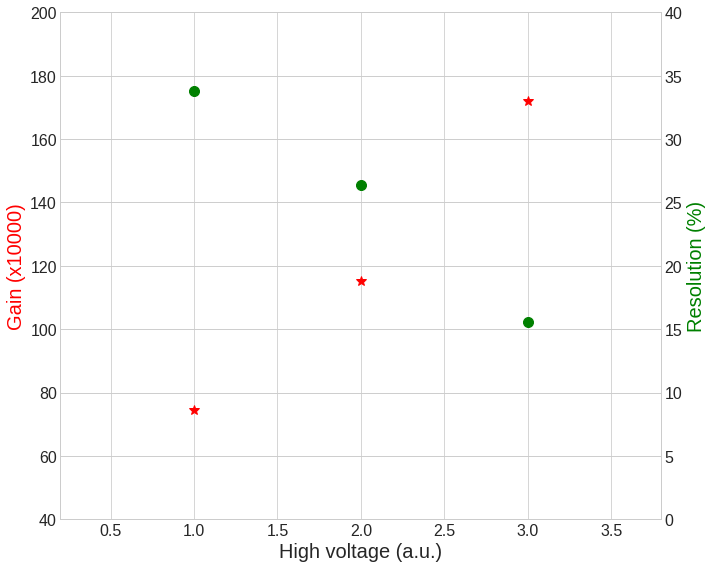

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.errorbar( (1,2,3) ,np.divide(gains,1e4), np.divide(gains_error,1e4) , marker='*',markersize=10, ls='None', color ='r', lw=3, label="gain")

ax2 = ax.twinx()
ax2.errorbar( (1,2,3) ,resolutions, resolutions_error, marker="o", markersize=10, color ='g',  lw=3, ls='None', label="resolution")

ax.set_xlabel("High voltage (a.u.)")
ax.set_ylabel("Gain (x10000)", color='r')
ax.tick_params('y')
ax.set_ylim(40,200)
ax.set_xlim(0.2,3.8)

ax2.set_ylabel('Resolution (%)', color='g')
ax2.tick_params('y')
ax2.set_ylim(0,40)

plt.tight_layout()
fig.savefig("plots/Electron_Gain_Resolution_HV_VME.pdf")

## 4) Data Analysis Part 2: Electron Setup with CAMAC ADC and $\chi^2$ fit

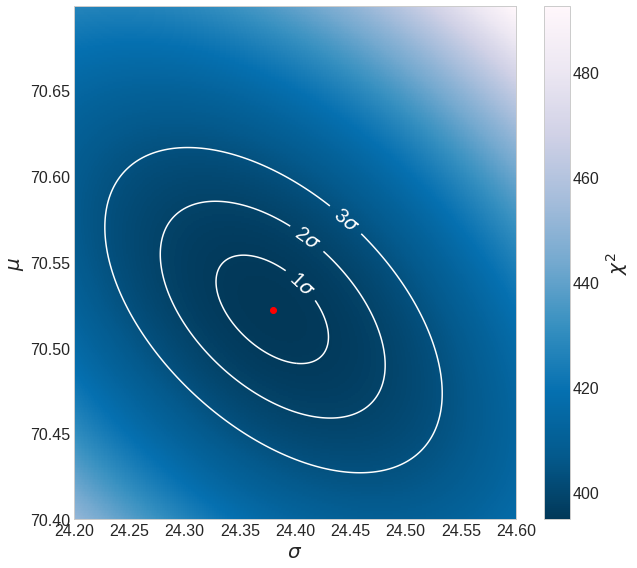

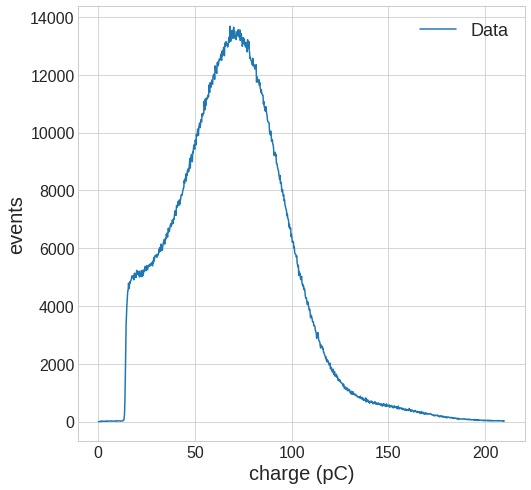

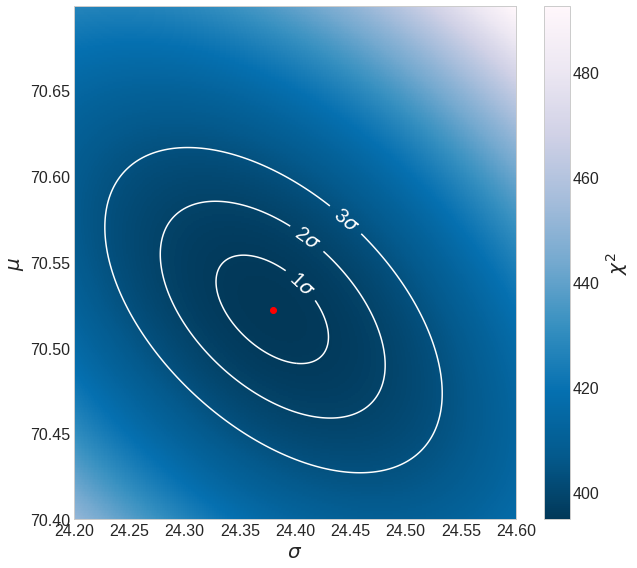

In [23]:
adcToCharge_CAMAC = 0.21
Exp_data_CAMAC = np.loadtxt('exampleData/electronSetup_CamacADC_1750_120.dat')
nADCBins = len(Exp_data_CAMAC)
chargeBins = np.linspace(0,nADCBins*adcToCharge_CAMAC,nADCBins+1)
chargeBinCenters = (chargeBins[:-1]+chargeBins[1:])/2

Electron_fit_chi2_CAMAC = GaussFit('chi2')
Electron_fit_chi2_CAMAC.setMuGrid(70.4,70.7,0.001)
Electron_fit_chi2_CAMAC.setSigmaGrid(24.2,24.6,0.001)
Electron_fit_chi2_CAMAC.setFitRange(50,100)
Electron_fit_chi2_CAMAC.fit([Exp_data_CAMAC,chargeBins])
Electron_fit_chi2_CAMAC.plotLikelihood()
#Electron_fit_chi2_CAMAC.plotResult([adcToCharge_CAMAC,chargeBins],100,'Charge (pC)','events','Data')
